In [148]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
import pandas as pd
from mlforecast import MLForecast
from xgboost import XGBRegressor
from utilsforecast.plotting import plot_series
from matplotlib import pyplot as plt
from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max
from mlforecast.target_transforms import Differences
from sklearn.metrics import mean_squared_error, accuracy_score ,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
import numpy as np
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import STL
from lightgbm import LGBMRegressor
from scipy.signal import periodogram
# from skmetrics import smape


from update_and_predict import update_and_predict as up

In [149]:

# def trainandupdate(test,train,ftsc,seasonal_period):
#     stl = STL(train['y'],period=seasonal_period)
#     result=stl.fit()
#     trend=result.trend
#     seasonal=result.seasonal
#     a=pd.DataFrame(trend)
#     a['ds']=df1['ds']
#     a['id_col']=df1['unique_id']
#     a['y']=a['trend']
#     a=a.dropna().reset_index(drop=True)

#     ftsc.ts.update(df=a)
#     ftsc.fit(df=ftsc.ts.df,id_col='unique_id',time_col='ds',target_col='y')

#     predictions = ftsc.predict(test.shape[0])

#     seasonalx = np.tile(seasonal[-seasonal_period:], int(np.ceil( test.shape[0] / seasonal_period)))[:test.shape[0]]
#     seasonalx = pd.Series(seasonalx, index=test.index)
#     seasonalx=pd.DataFrame(seasonalx)
#     seasonalx['ds']=pd.to_datetime(test['ds'])
#     seasonalx['y']=seasonalx[0]
#     seasonalx['unique_id']='h1'
#     seasonalx=seasonalx.reset_index()

#     predictions['seas+xgb']=predictions['XGBRegressor']*(seasonalx['y'])
#     predictions['seas+xgb']=(predictions['seas+xgb']/a['y'].mean())+a['y'].mean()
#     predictions['seas+lgb']=predictions['LGBMRegressor']*(seasonalx['y'])
#     predictions['seas+lgb']=(predictions['seas+lgb']/a['y'].mean())+a['y'].mean()

#     rmse_xgb,rmse_lgb=root_mean_squared_error(test['y'],predictions['seas+xgb']),root_mean_squared_error(test['y'],predictions['seas+lgb'])
#     return ftsc,rmse_xgb,rmse_lgb
#     # p=predictions.copy()
#     # p.drop(columns=['XGBRegressor','LGBMRegressor'],inplace=True)
#     # p.head()
    

In [150]:
df=pd.read_csv('MLTempDataset.csv')
df.drop(columns=['Unnamed: 0',],inplace=True)#'Datetime1'
df1=df.copy()
df1['unique_id']='h1'
# df1['unique_id']=
df1['ds']=pd.to_datetime(df['Datetime'])
df1['y']=df['DAYTON_MW']
df1.drop(columns=['Datetime','DAYTON_MW','Datetime1'],inplace=True)
df1.head()

chunks=[]
r=int(df1.shape[0]/5)
for i in range(4):
    a=df1[i*r:(i+1)*r]
    chunks.append(a)
chunks.append(df1[4*r:])

In [151]:
initial_train=chunks[0]

In [152]:
frequencies, spectrum = periodogram(initial_train['y'])
max_idx = np.argmax(spectrum)
second_max_idx = np.argsort(spectrum)[-2]  # Get the second largest index

# Get the maximum and second maximum values
max_value = spectrum[max_idx]
second_max_value = spectrum[second_max_idx]

# Get the corresponding frequencies
max_freq = frequencies[max_idx]
second_max_freq = frequencies[second_max_idx]

1/max_freq, 1/second_max_freq

# plt.figure(figsize=(14, 7))
# plt.plot(frequencies, spectrum)
# plt.title('Periodogram')
# plt.xlabel('Frequency')
# plt.ylabel('Power')
# plt.show()

seasonal_period=int(1/second_max_freq)
seasonal_period

667

In [153]:
model=XGBRegressor(random_state=990,learning_rate=0.01,n_estimators=500,max_depth=10,reg_lambda=0.2)
model2=LGBMRegressor(boosting_type='gbdt',num_leaves=31,learning_rate=0.1,n_estimators=100,random_state=990,verbose=-1)
ftsc=MLForecast(
    models=[model,model2],
    freq='H',
    lags=[seasonal_period],
    lag_transforms={
        # 30:[(rolling_mean,30),(rolling_std,30),(rolling_min,30),(rolling_max,30)],
        # 168:[(rolling_mean,168),(rolling_std,168),(rolling_min,168),(rolling_max,168)],
        seasonal_period:[(rolling_mean,seasonal_period),(rolling_std,seasonal_period),(rolling_min,seasonal_period),(rolling_max,seasonal_period)],
    #     350:[(rolling_mean,350),(rolling_std,350),(rolling_min,350),(rolling_max,350)],
    #     720:[(rolling_mean,720),(rolling_std,720),(rolling_min,720),(rolling_max,720)]
    },
    # target_transforms=[Differences([350])],
    date_features=['hour','day','weekday','month','year'],
)

In [154]:
ftsc.fit(initial_train)

MLForecast(models=[XGBRegressor, LGBMRegressor], freq=H, lag_features=['lag667', 'rolling_mean_lag667_window_size667', 'rolling_std_lag667_window_size667', 'rolling_min_lag667_window_size667', 'rolling_max_lag667_window_size667'], date_features=['hour', 'day', 'weekday', 'month', 'year'], num_threads=1)

In [155]:
preds=[]
tests=[]

In [156]:
for i in range(4):
    train=chunks[i]
    test=chunks[i+1]
    ftsc,rmse_xgb,rmse_lgb,predictions=up(train,test,ftsc)
    preds.append(predictions)
    tests.append(test)

In [157]:
len(preds)

4

In [158]:
for i,p in enumerate(preds):
    p['y']=p['seas+xgb']   
    print(p.shape)
    print(tests[i].shape)
    print(f"{i}-->mean_absolute_error  {mean_absolute_error(p['y'], tests[i]['y'])}")
    print(f"{i}-->mean_absolute_percentage_error  {mean_absolute_percentage_error(p['y'], tests[i]['y'])}")
    print(f"{i}-->r2_score  {r2_score(p['y'], tests[i]['y'])}")
    print(f"{i}-->mean_squared_error  {mean_squared_error(p['y'], tests[i]['y'])}")

(1335, 7)
(1335, 3)
0-->mean_absolute_error  8.60090996872891
0-->mean_absolute_percentage_error  0.6255366840183055
0-->r2_score  -1.8581945993800573
0-->mean_squared_error  106.37644053716397
(1335, 7)
(1335, 3)
1-->mean_absolute_error  8.15313106731605
1-->mean_absolute_percentage_error  0.33386446220050964
1-->r2_score  -5.813875909318165
1-->mean_squared_error  101.82185888397437
(1335, 7)
(1335, 3)
2-->mean_absolute_error  7.398463475760099
2-->mean_absolute_percentage_error  0.40035954417973235
2-->r2_score  -0.9685927943992032
2-->mean_squared_error  86.432959932757
(1336, 7)
(1336, 3)
3-->mean_absolute_error  6.466540277937347
3-->mean_absolute_percentage_error  0.5024472557863315
3-->r2_score  -0.912457281960162
3-->mean_squared_error  74.63958639408462


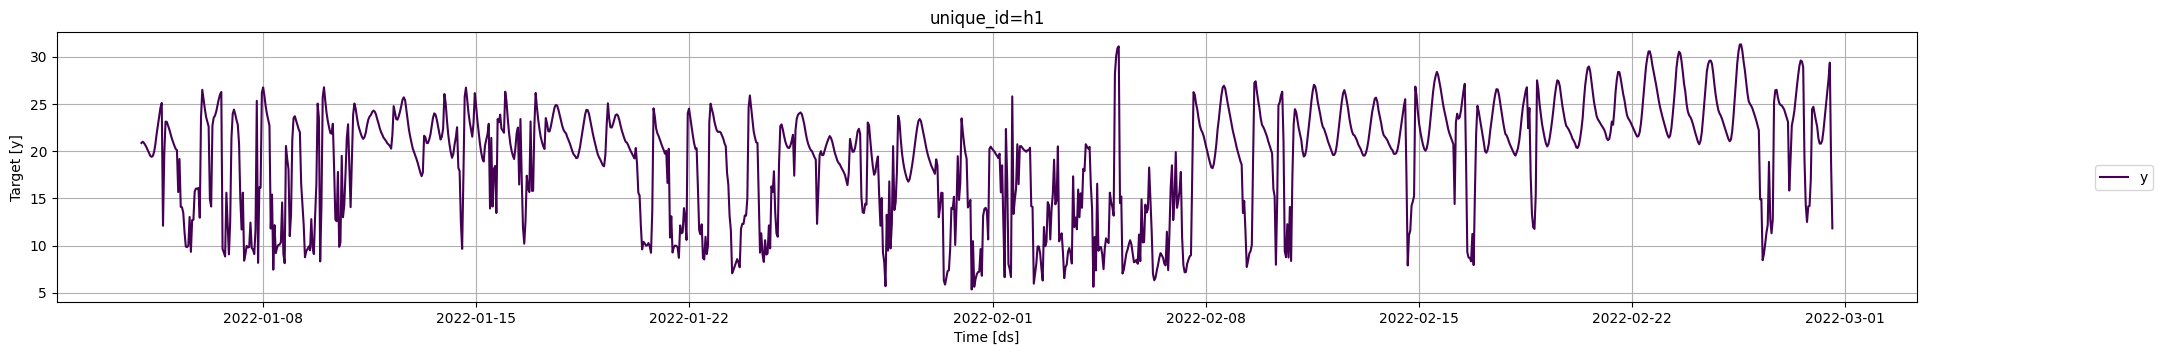

In [159]:
plot_series(chunks[0])

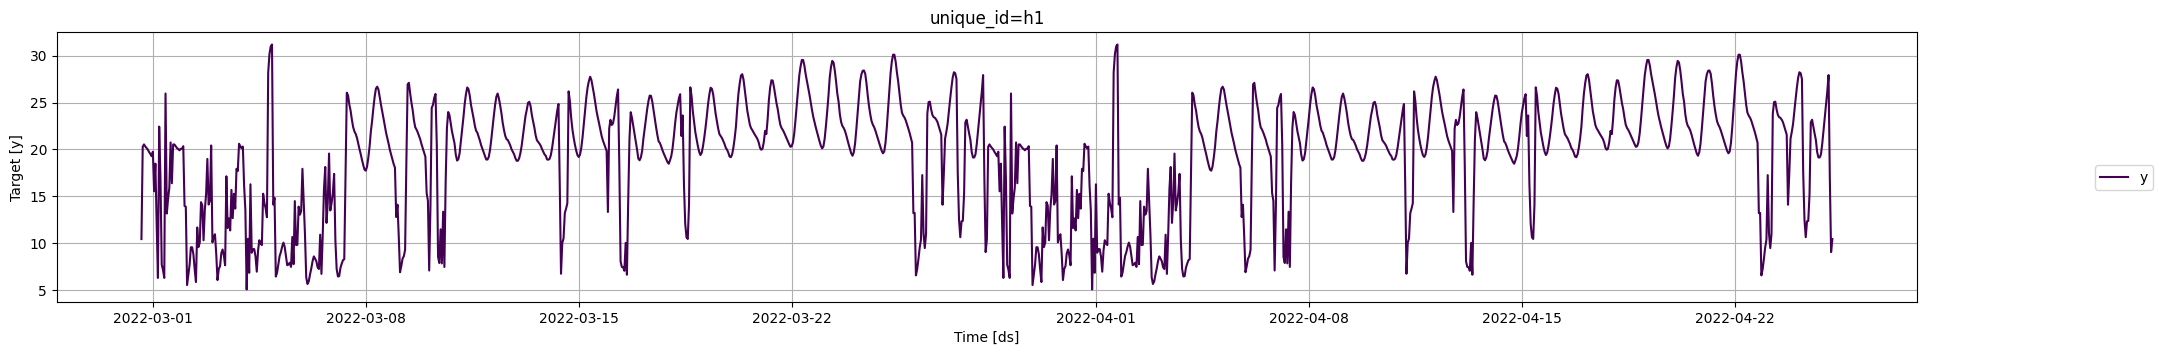

In [160]:
plot_series(preds[0])

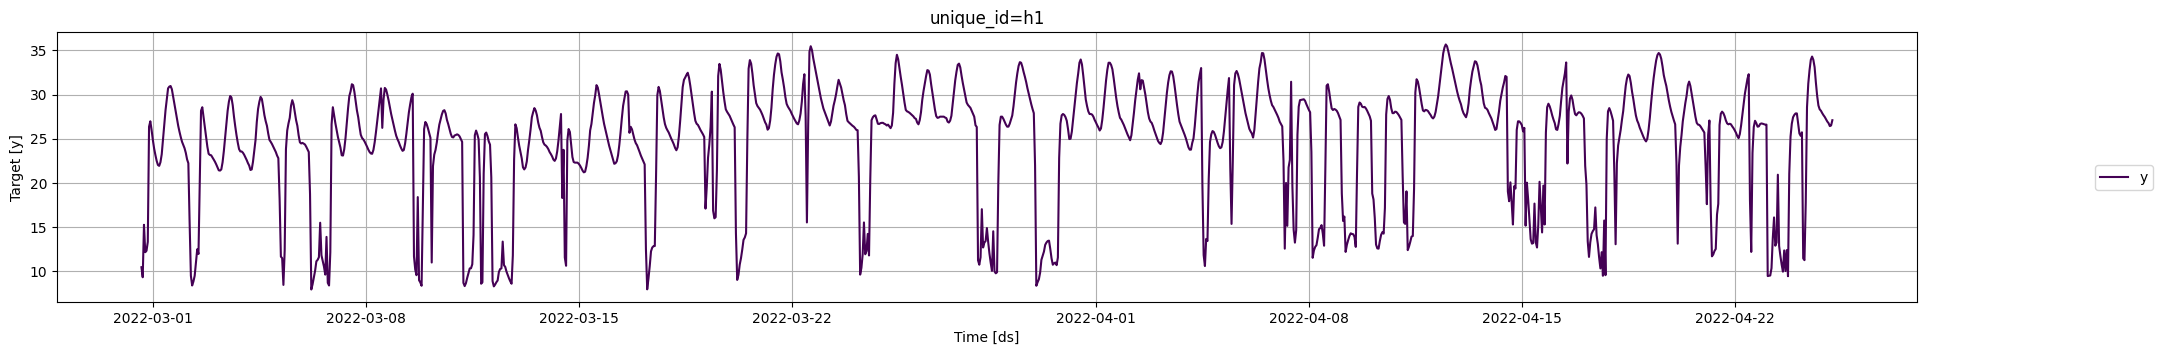

In [161]:
plot_series(tests[0])

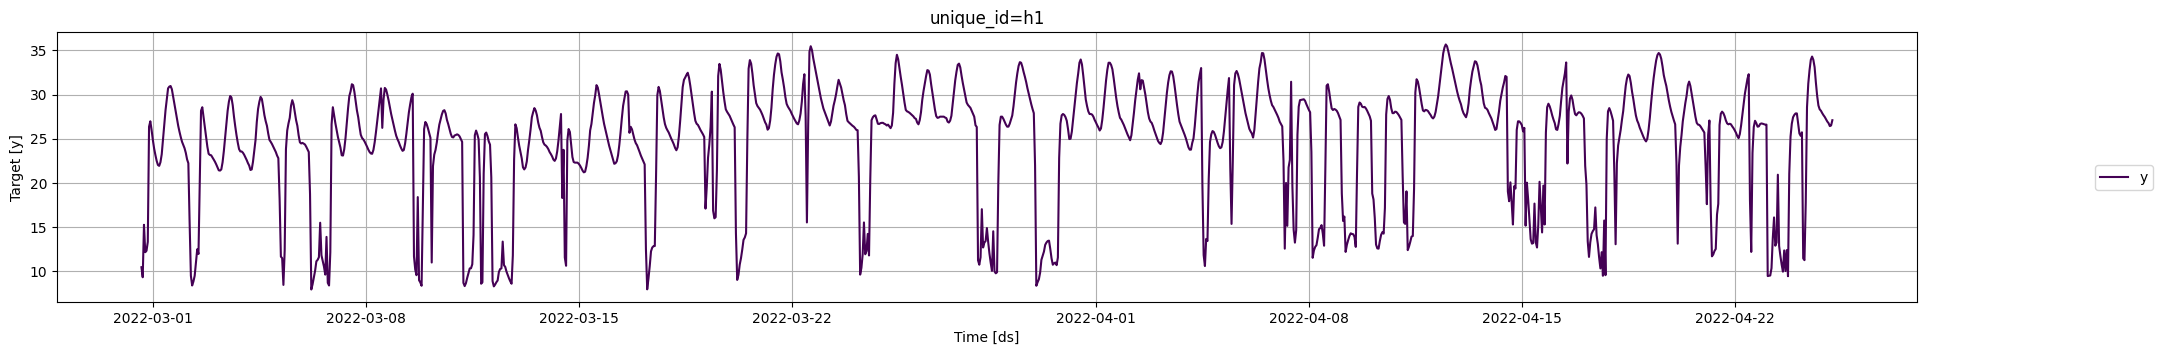

In [162]:
plot_series(chunks[1])

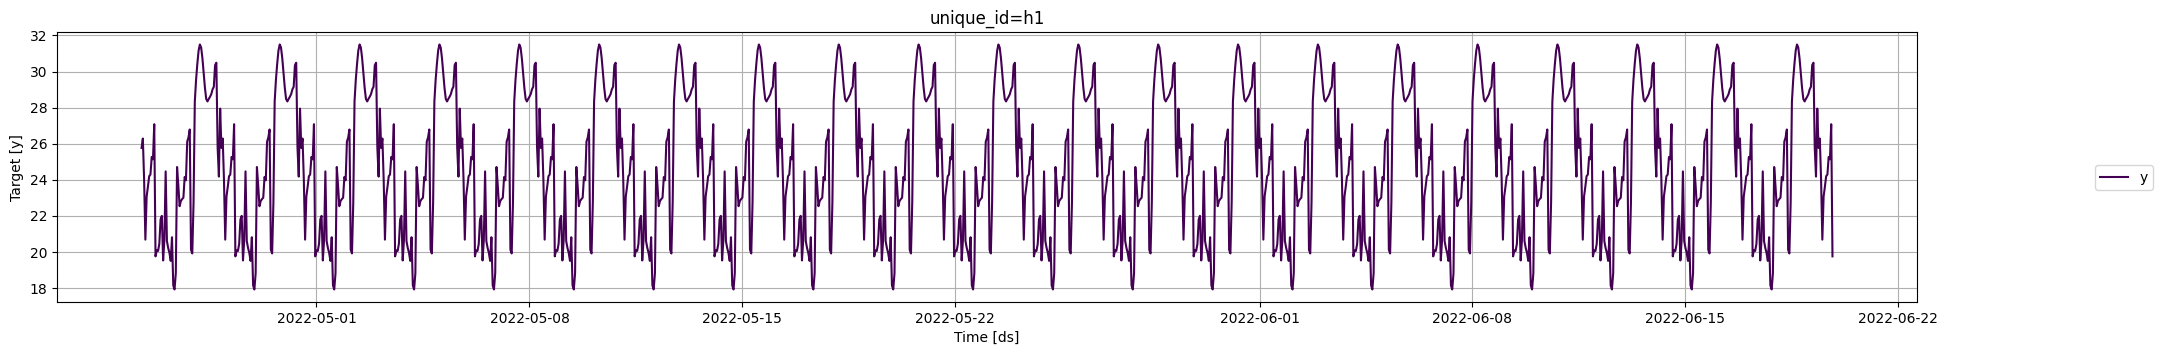

In [163]:
plot_series(preds[1])

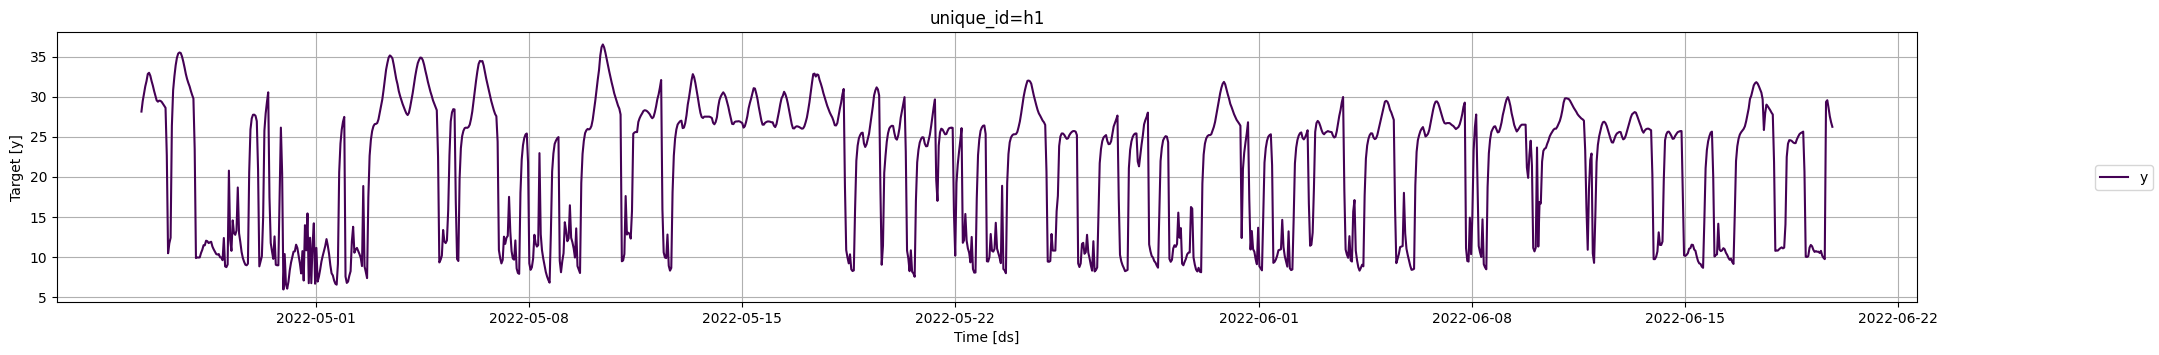

In [164]:
plot_series(tests[1])

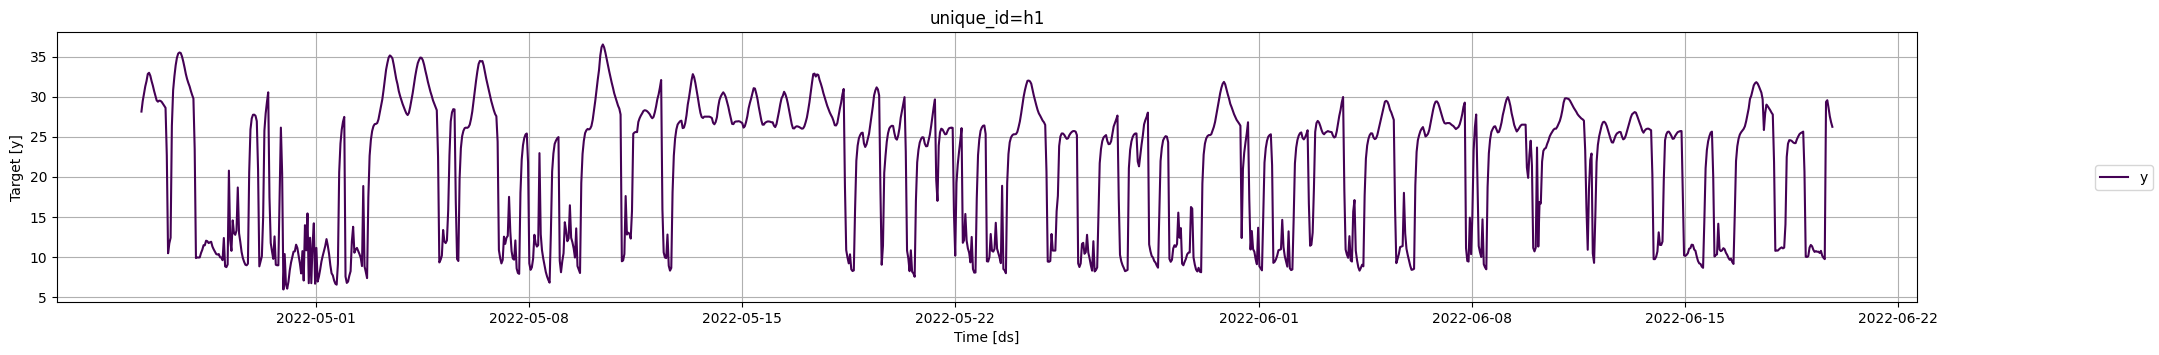

In [165]:
plot_series(chunks[2])

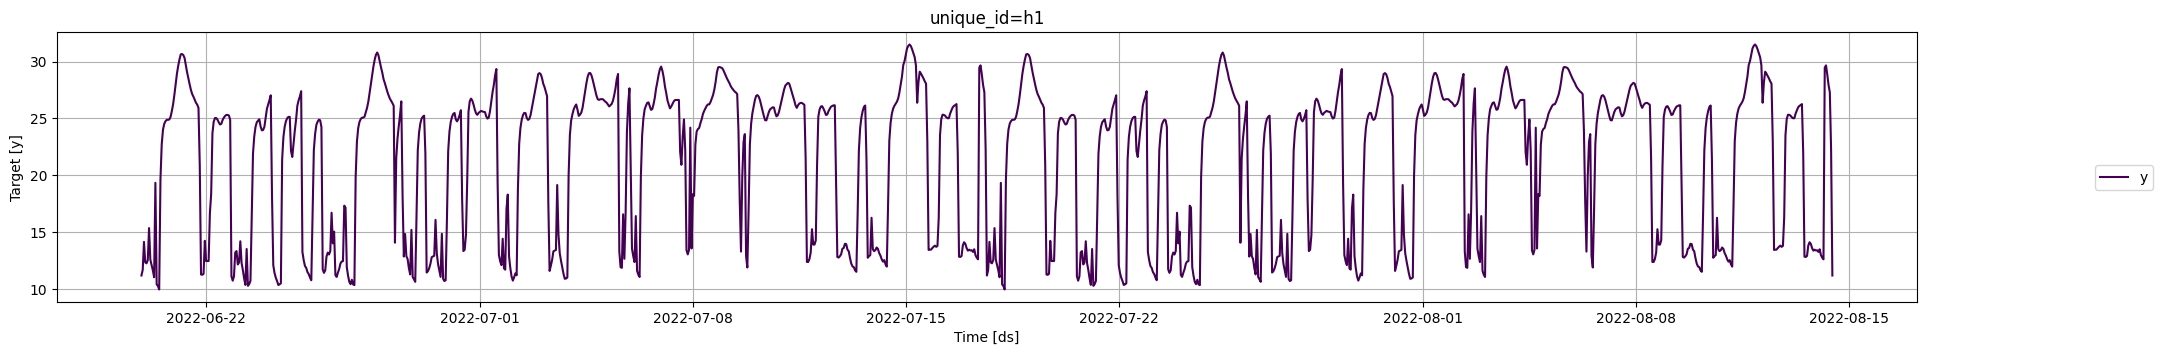

In [166]:
plot_series(preds[2])

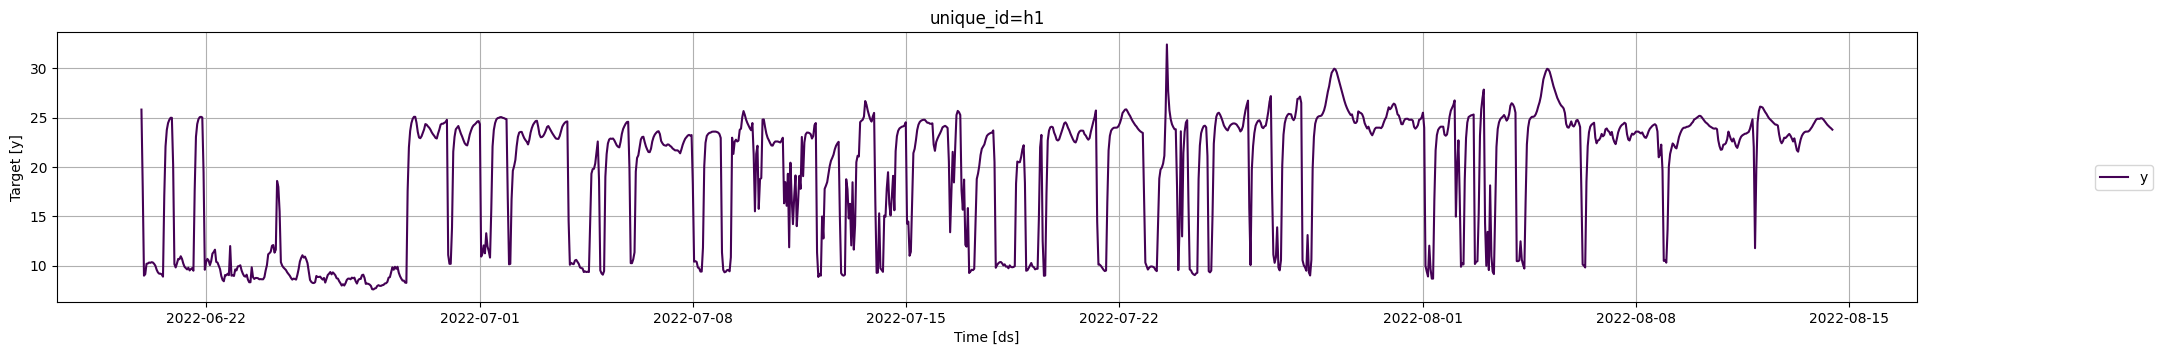

In [167]:
plot_series(tests[2])

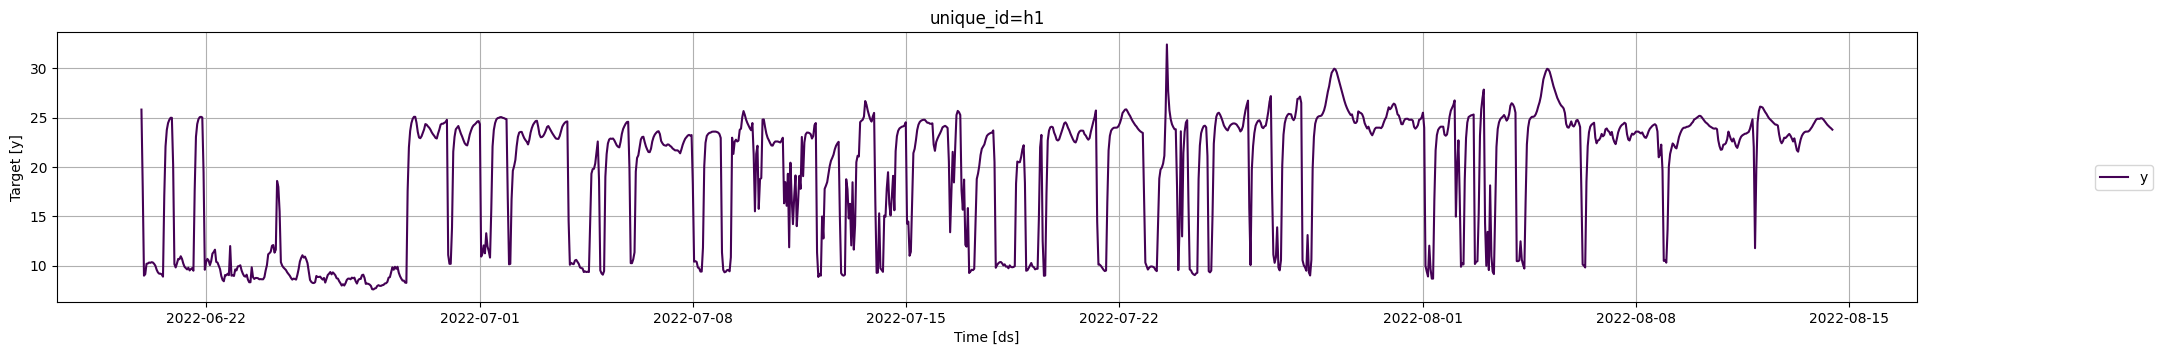

In [168]:
plot_series(chunks[3])

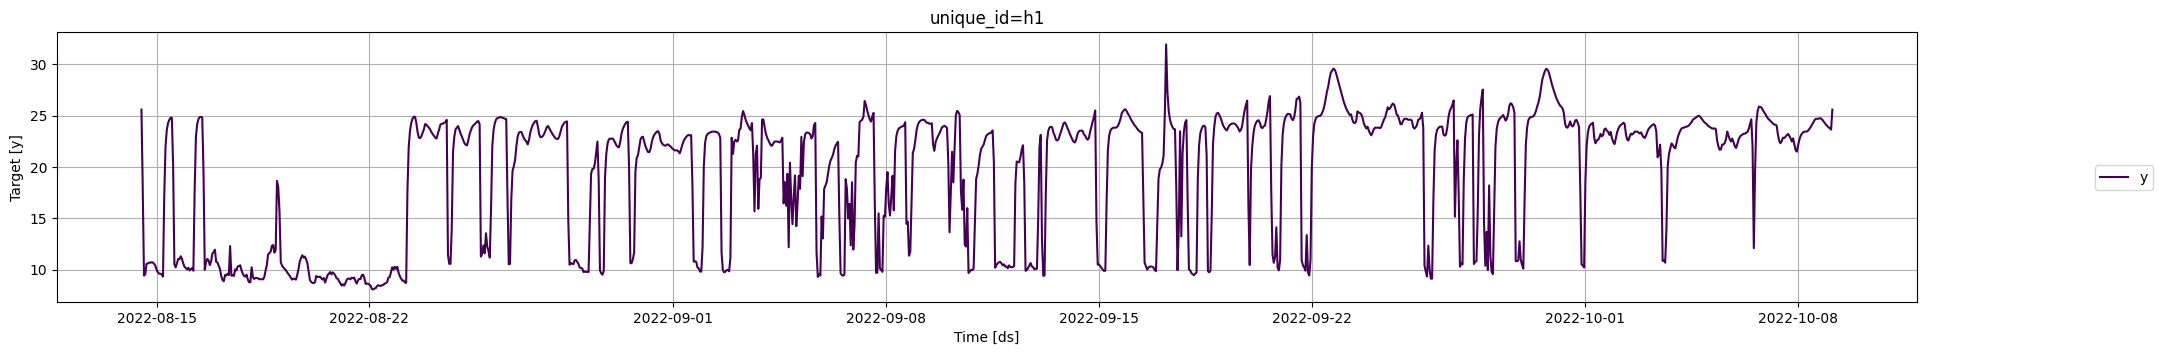

In [169]:
plot_series(preds[3])

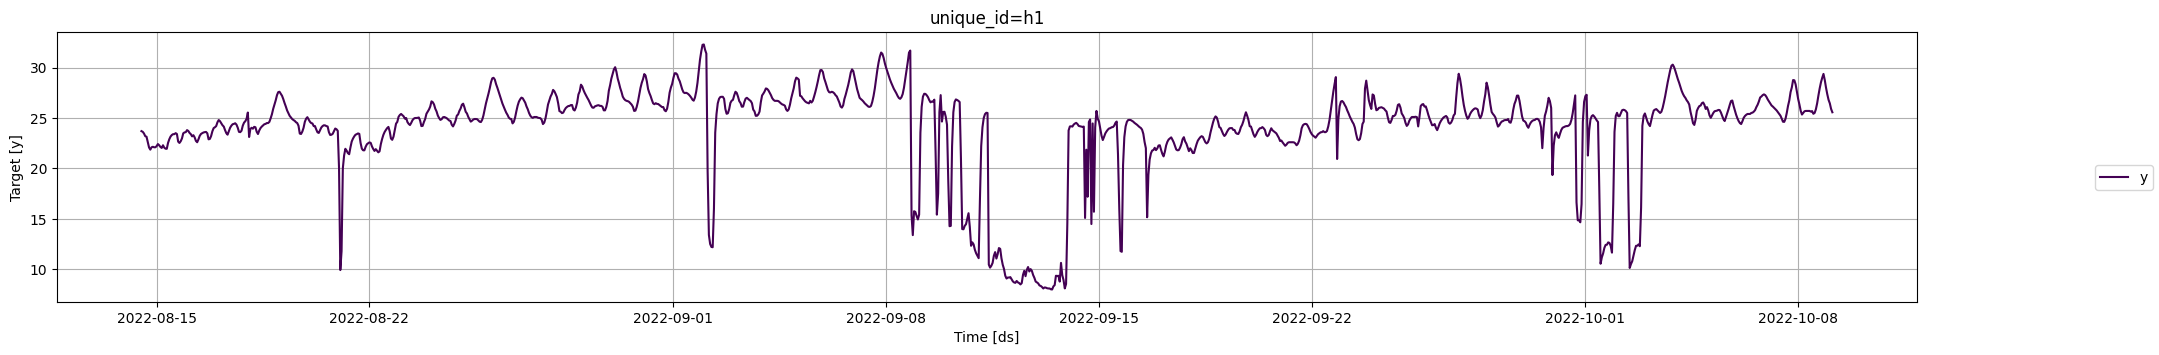

In [170]:
plot_series(tests[3])

In [ ]:
predictions['y']=predictions['seas+xgb']
plot_series(predictions)
plot_series(test)
rmse_xgb,rmse_lgb
mean_absolute_error(predictions['y'], test['y'])
mean_absolute_percentage_error(predictions['y'], test['y'])
r2_score(predictions['y'], test['y'])
mean_squared_error(predictions['y'], test['y'])

In [63]:
# train=chunks[0]
# test=chunks[1]

In [34]:
# train.head()

,unique_id,ds,y
4005,h1,2022-06-19 21:00:00,25.833
4006,h1,2022-06-19 22:00:00,18.000
4007,h1,2022-06-19 23:00:00,9.000
4008,h1,2022-06-20 00:00:00,9.150
4009,h1,2022-06-20 01:00:00,10.200


In [35]:
# ftsc,rmse_xgb,rmse_lgb,predictions=up(train,test,ftsc)

In [36]:
# stl = STL(train['y'],period=seasonal_period)
# result=stl.fit()
# trend=result.trend
# seasonal=result.seasonal
# a=pd.DataFrame(trend)
# a['ds']=df1['ds']
# a['unique_id']=df1['unique_id']
# a['y']=a['trend']
# a=a.dropna().reset_index(drop=True)

In [37]:
# ftsc.ts.update(a)
# # ftsc.fit(a)

In [38]:


# predictions = ftsc.predict(test.shape[0])

# seasonalx = np.tile(seasonal[-seasonal_period:], int(np.ceil( test.shape[0] / seasonal_period)))[:test.shape[0]]
# seasonalx = pd.Series(seasonalx, index=test.index)
# seasonalx=pd.DataFrame(seasonalx)
# seasonalx['ds']=pd.to_datetime(test['ds'])
# seasonalx['y']=seasonalx[0]
# seasonalx['unique_id']='h1'
# seasonalx=seasonalx.reset_index()

# predictions['seas+xgb']=predictions['XGBRegressor']*(seasonalx['y'])
# predictions['seas+xgb']=(predictions['seas+xgb']/a['y'].mean())+a['y'].mean()
# predictions['seas+lgb']=predictions['LGBMRegressor']*(seasonalx['y'])
# predictions['seas+lgb']=(predictions['seas+lgb']/a['y'].mean())+a['y'].mean()

# rmse_xgb,rmse_lgb=root_mean_squared_error(test['y'],predictions['seas+xgb']),root_mean_squared_error(test['y'],predictions['seas+lgb'])
# ftsc,rmse_xgb,rmse_lgb

In [39]:
predictions['y']=predictions['seas+xgb']

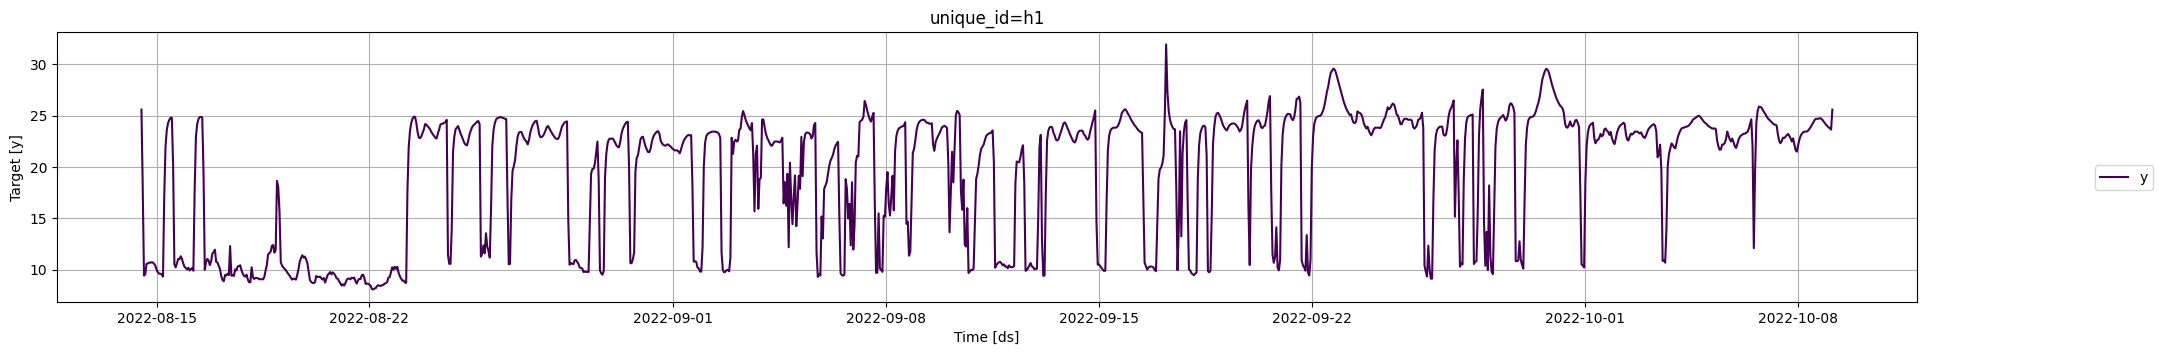

In [40]:
plot_series(predictions)

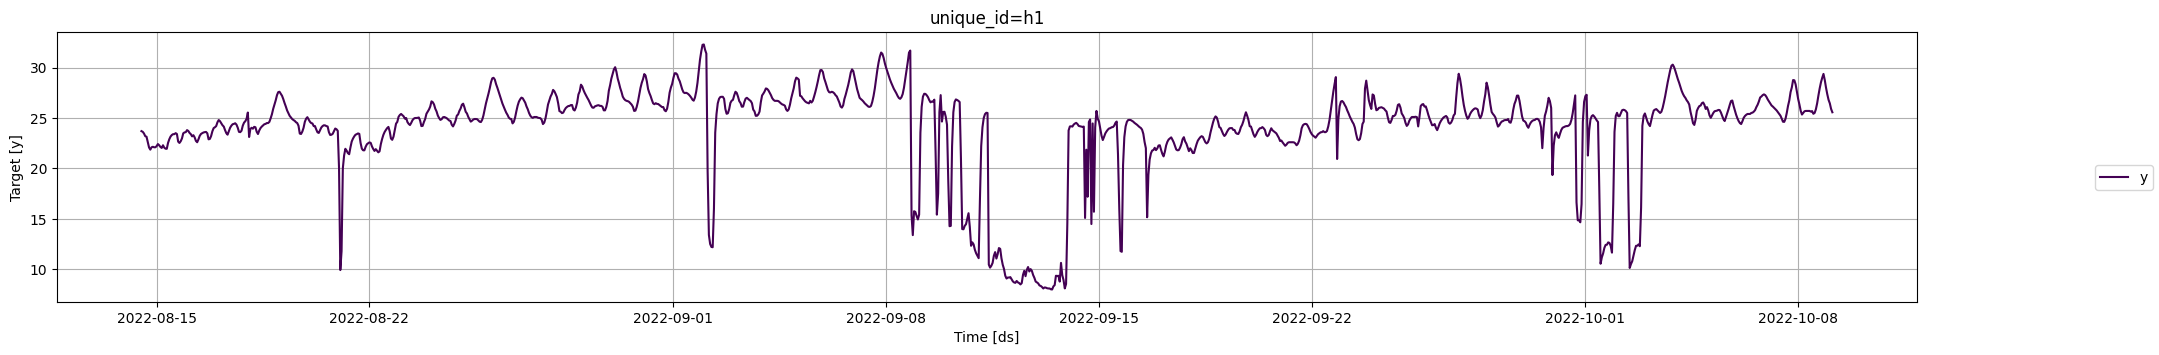

In [41]:
plot_series(test)

In [42]:
rmse_xgb,rmse_lgb

(np.float64(8.639420489482186), np.float64(7.932149685886204))

In [48]:
mean_absolute_error(predictions['y'], test['y'])
mean_absolute_percentage_error(predictions['y'], test['y'])
r2_score(predictions['y'], test['y'])
mean_squared_error(predictions['y'], test['y'])

np.float64(6.466540277937347)

np.float64(0.5024472557863315)

-0.912457281960162

In [92]:
6675*60

400500